# Llama Model for Classifying Misleading Images

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
hf_token = os.environ.get("HF_TOKEN")

model_id = "meta-llama/Meta-Llama-3.1-70B-Instruct"
cache_dir = "./"

tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=cache_dir,token= hf_token)
# Load the model and move sit to GPU 1
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    cache_dir=cache_dir,
    device_map="auto",  # enables automatic GPU placement
    token= hf_token)

Loading checkpoint shards: 100%|██████████| 30/30 [03:24<00:00,  6.81s/it]


In [6]:
import torch
torch.cuda.empty_cache()

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model and tokenizer

# Prepare the input prompt
def prepare_prompt(row):
    return f"""You will be given a fact, a correct statement, a false statement, and a tweet (inside triple backticks).  
Your task is to classify the relationship between the tweet and the fact. 
First, decide whether the tweet is **irrelevant** to the fact.  
If the tweet is relevant, determine whether it supports or refutes the fact.

Respond with only one of the following labels:  [irrelevant, supporting, or refuting] 
Do not provide any explanation.

Fact: {row['fact']}  
Correct Statement: {row['supporting']}  
False Statement: {row['refuting']}  
Tweet: ```{row['tweet_text']}```"""

# Generate stance for each row
def get_stance(row):
    input_text = prepare_prompt(row)
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
    
    # Generate model output
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
        do_sample=True
    )
    
    # Decode model output
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(response)
    return response

# Load dataset
df = pd.read_csv("ann_dataset_misleading.csv")
df = df[df['Final Labeling'].notna() & (df['Final Labeling'].str.strip() != '')]
# Apply stance generation function to the entire DataFrame
df['stance_llama_70_b_new_val'] = df.apply(get_stance, axis=1)
# Save the entire DataFrame to one CSV
df.to_csv("final_results_2.csv", index=False)
print("All results saved to final_results.csv")

In [ ]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = pipeline(
    messages,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
print(outputs[0]["generated_text"][-1])

In [ ]:
pip install openai


In [ ]:
import pandas as pd
from openai import OpenAI

api_key = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
client = OpenAI(api_key = api_key)
hf_token = os.getenv("HF_TOKEN")


def prepare_prompt(row):
    """
    Prepares the input prompt for the stance classification task.
    """
    return f"""You will be provided with a tweet, delimited by triple backticks, related to the given fact, correct statement, and false statement. Indicate whether the tweet supports, refutes, or is neutral regarding the fact.
    Your response should be one of the following: [supporting, refuting, neutral]. Do not include any explanation.
Fact: {row['fact']}
Correct Statement: {row['supporting']}
False Statement: {row['refuting']}
Tweet: {row['tweet_text']}
    """


def get_stance(row):
    """
    Sends the prepared prompt to the OpenAI model and returns the response.
    """
    prompt_text = prepare_prompt(row)
    
    try:
        # Send the prompt to the OpenAI API
        completion = client.chat.completions.create(
            model="meta/llama-3.1-70b-instruct",
            messages=[{"role": "user", "content": prompt_text}],
            temperature=0.2,
            top_p=0.7,
            max_tokens=1024,
            stream=True
        )
        
        for chunk in completion:
          if chunk.choices[0].delta.content is not None:
            print(chunk.choices[0].delta.content, end="")

    
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return "error"

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")
# Apply the model to each row and create a new column
df['stance_llama_api_final'] = df.apply(get_stance, axis=1)
# Save the updated dataframe
#df.to_csv("final_results.csv", index=False)

print("Processing complete. Results saved to 'updated_stance_results.csv'.")


neutralProcessing complete. Results saved to 'updated_stance_results.csv'.


In [ ]:


def prepare_prompt(row):
    """
    Prepares the input prompt for the stance classification task.
    """
    return f"""You will be provided with a tweet, delimited by triple backticks, related to the given fact, correct statement, and false statement. Indicate whether the tweet supports or refutes regarding the fact.
    Your response should be one of the following: [supporting, refuting]. Do not include any explanation.
Fact: {row['fact']}
Correct Statement: {row['supporting']}
False Statement: {row['refuting']}
Tweet: {row['tweet_text']}
    """
def get_stance(row):
    prompt_text = prepare_prompt(row)
    completion = client.chat.completions.create(
      model="meta/llama-3.1-70b-instruct",
      messages=[{"role":"user","content": prompt_text}],
      temperature=0.2,
      top_p=0.7,
      max_tokens=1024,
      stream=False
    )
    response_text = completion.choices[0].message.content.strip()
    print(response_text)
    return response_text
df = pd.read_csv("multimodal-playground/ann_dataset_misleading.csv")
# Apply the model to each row and create a new column
df['stance_llama_api_final'] = df.apply(get_stance, axis=1)
# Save the updated dataframe
df.to_csv("final_results_2.csv", index=False)

print("Processing complete. Results saved to 'updated_stance_results.csv'.")

# Cross Encoder Models for Topic Relevancy for Misleading Images

# MixedBread AI

In [2]:
from sentence_transformers import CrossEncoder
cache_dir = "./"

    
# Load the model, here we use our base sized model
# Load the model
model = CrossEncoder(
    "mixedbread-ai/mxbai-rerank-large-v1",
device="cuda:0",    cache_dir=cache_dir
)
# Example query and documents


In [3]:
query = "Who wrote 'To Kill a Mockingbird'?"
documents = [
    "'To Kill a Mockingbird' is a novel by Harper Lee published in 1960. It was immediately successful, winning the Pulitzer Prize, and has become a classic of modern American literature.",
    "The novel 'Moby-Dick' was written by Herman Melville and first published in 1851. It is considered a masterpiece of American literature and deals with complex themes of obsession, revenge, and the conflict between good and evil.",
    "Harper Lee, an American novelist widely known for her novel 'To Kill a Mockingbird', was born in 1926 in Monroeville, Alabama. She received the Pulitzer Prize for Fiction in 1961.",
    "Jane Austen was an English novelist known primarily for her six major novels, which interpret, critique and comment upon the British landed gentry at the end of the 18th century.",
    "The 'Harry Potter' series, which consists of seven fantasy novels written by British author J.K. Rowling, is among the most popular and critically acclaimed books of the modern era.",
    "'The Great Gatsby', a novel written by American author F. Scott Fitzgerald, was published in 1925. The story is set in the Jazz Age and follows the life of millionaire Jay Gatsby and his pursuit of Daisy Buchanan."
]

# Lets get the scores
results = model.rank(query, documents, return_documents=True, top_k=3)
# Extract scores
scores = [item['score'] for item in results]
text = [item['text'] for item in results]

print(scores)
print(text)

[np.float32(0.99801946), np.float32(0.9969399), np.float32(0.0294786)]
["'To Kill a Mockingbird' is a novel by Harper Lee published in 1960. It was immediately successful, winning the Pulitzer Prize, and has become a classic of modern American literature.", "Harper Lee, an American novelist widely known for her novel 'To Kill a Mockingbird', was born in 1926 in Monroeville, Alabama. She received the Pulitzer Prize for Fiction in 1961.", "'The Great Gatsby', a novel written by American author F. Scott Fitzgerald, was published in 1925. The story is set in the Jazz Age and follows the life of millionaire Jay Gatsby and his pursuit of Daisy Buchanan."]


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import CrossEncoder

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")

# Group rows by 'fact' and collect corresponding tweets
grouped = df.groupby('fact')['tweet_text'].apply(list).reset_index()
grouped.columns = ['fact', 'documents']

# Prepare a DataFrame to store the results
results_list = []

# Iterate over each fact and its associated documents
for _, row in grouped.iterrows():
    fact = row['fact']  # Query
    documents = row['documents']  # List of tweets
    results = model.rank(fact, documents, return_documents=True, top_k=len(documents))  # Rank all documents

    # Map the scores back to the original DataFrame rows
    for result in results:
        results_list.append({
            'fact': fact,
            'tweet_text': result['text'],
            'score_mixedbread_fact': round(result['score'], 4)
        })

# Convert results into a DataFrame
results_df_fact = pd.DataFrame(results_list)

# Group rows by 'fact' and collect corresponding tweets
grouped = df.groupby('supporting')['tweet_text'].apply(list).reset_index()
grouped.columns = ['supporting', 'documents']

# Prepare a DataFrame to store the results
results_list = []

# Iterate over each fact and its associated documents
for _, row in grouped.iterrows():
    supporting = row['supporting']  # Query
    documents = row['documents']  # List of tweets
    results = model.rank(supporting, documents, return_documents=True, top_k=len(documents))  # Rank all documents

    # Map the scores back to the original DataFrame rows
    for result in results:
        results_list.append({
            'supporting': supporting,
            'tweet_text': result['text'],
            'score_mixedbread_supporting': round(result['score'], 4)
        })

# Convert results into a DataFrame
results_df_supporting = pd.DataFrame(results_list)

# Group rows by 'fact' and collect corresponding tweets
grouped = df.groupby('refuting')['tweet_text'].apply(list).reset_index()
grouped.columns = ['refuting', 'documents']

# Prepare a DataFrame to store the results
results_list = []

# Iterate over each fact and its associated documents
for _, row in grouped.iterrows():
    refuting = row['refuting']  # Query
    documents = row['documents']  # List of tweets
    results = model.rank(refuting, documents, return_documents=True, top_k=len(documents))  # Rank all documents

    # Map the scores back to the original DataFrame rows
    for result in results:
        results_list.append({
            'refuting': fact,
            'tweet_text': result['text'],
            'score_mixedbread_refuting': round(result['score'], 4)
        })

# Convert results into a DataFrame
results_df_refuting = pd.DataFrame(results_list)
# Merging all dataframes on 'tweet_text' column
merged_df = pd.merge(results_df_fact, results_df_supporting, on="tweet_text", how="outer")
merged_df = pd.merge(merged_df, results_df_refuting, on="tweet_text", how="outer")

# Taking the maximum score across all score columns
merged_df["max_score_mixedbread_new_val"] = merged_df[["score_mixedbread_refuting", "score_mixedbread_supporting", "score_mixedbread_fact"]
].min(axis=1)
# Creating a new DataFrame with only the necessary columns
results_df_max = merged_df[["tweet_text", "max_score_mixedbread_new_val"]]
print(results_df_fact)
# Displaying the results
results_df_max

#Merge the original DataFrame with the scores DataFrame on 'fact' and 'tweet_text'
merged_df = pd.merge(df, results_df_max, on=['tweet_text'], how='left')

# Save the updated DataFrame to a new CSV
merged_df.to_csv("updated_stance_results_with_max_mixedbread_scores.csv", index=False)

# Print a sample of the updated DataFrame
print(merged_df.head())

                                                  fact  \
0    Any pauses in counting were part of routine pr...   
1    Any pauses in counting were part of routine pr...   
2    Any pauses in counting were part of routine pr...   
3    Any pauses in counting were part of routine pr...   
4    Any pauses in counting were part of routine pr...   
..                                                 ...   
817  This image, claimed to show discarded 2020 bal...   
818  This image, claimed to show discarded 2020 bal...   
819  This image, claimed to show discarded 2020 bal...   
820  This image, claimed to show discarded 2020 bal...   
821  This image, claimed to show discarded 2020 bal...   

                                            tweet_text  score_mixedbread_fact  
0    Why Did Six Battleground States with Democrat ...                 0.4280  
1    Take a look at these 5 States that were all fa...                 0.4077  
2    The EXACT moment when all these swing states S...         

Optimal Threshold: 0.002203631036310363
Minimum Misclassification: 40
Misclassification Rate: 0.2312

Confusion Matrix:
[[ 20  32]
 [  8 113]]
                                           tweet_text  max_score_mixedbread_y  \
3   See how Demos add fake voters in WI and MI. ??...                  0.0078   
4   For Biden, it is considered that at the moment...                  0.0068   
6   Look at democrats mysterious jump to win after...                  0.0066   
13  I still have not heard an explanation of this....                  0.0035   
17  Michigan manufactures Biden Ballots outrageous...                  0.0048   

   Author Labeling Final Classification  
3         refuting                  NaN  
4         refuting                  NaN  
6         refuting                  NaN  
13        refuting                  NaN  
17        refuting                  NaN  


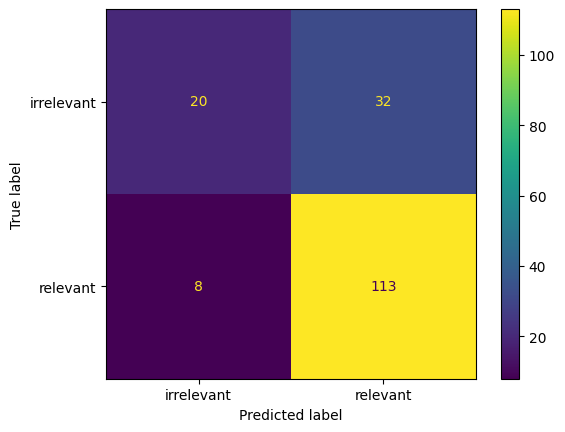

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")
# Map Author Labeling to binary classes
df['Author Labeling Binary'] = df['Author Labeling'].map({
    'irrelevant': 0,
    'refuting': 1,
    'supporting': 1
})

# Ensure there are no missing values in scores or labels
df = df.dropna(subset=['max_score_mixedbread_y', 'Author Labeling Binary'])

# Sweep through thresholds to find the optimal one
thresholds = np.linspace(df['max_score_mixedbread_y'].min(), df['max_score_mixedbread_y'].max(), 100000)  # 100 thresholds between min and max score
min_misclassification = float('inf')
optimal_threshold = None

for threshold in thresholds:
    # Predict based on the threshold
    df['Predicted Label'] = (df['max_score_mixedbread_y'] >= threshold).astype(int)

    # Calculate misclassification error
    misclassification = (df['Predicted Label'] != df['Author Labeling Binary']).sum()

    # Update optimal threshold
    if misclassification < min_misclassification:
        min_misclassification = misclassification
        optimal_threshold = threshold
df['Predicted Label'] = (df['max_score_mixedbread_y'] >= optimal_threshold).astype(int)

# Print the optimal threshold and the corresponding misclassification error
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Minimum Misclassification: {min_misclassification}")

# Apply the optimal threshold to classify tweets
df['Final Classification'] = (df['max_score_mixedbread_y'] >= optimal_threshold).map({0: 'irrelevant', 1: 'relevant'})

# Calculate Misclassification Rate
misclassification_rate = min_misclassification / len(df)
print(f"Misclassification Rate: {misclassification_rate:.4f}")

# Generate the Confusion Matrix
y_true = df['Author Labeling Binary']
y_pred = df['Predicted Label']
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['irrelevant', 'relevant']).plot()

# Save the results
df.to_csv("classified_stance_results.csv", index=False)

# Display a sample of the classified DataFrame
print(df[['tweet_text', 'max_score_mixedbread_y', 'Author Labeling', 'Final Classification']].head())

# BGE Ranker

In [ ]:
from FlagEmbedding import FlagReranker
cache_dir = "./"
reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True, cache_dir= cache_dir) # Setting use_fp16 to True speeds up computation with a slight performance degradation

score = reranker.compute_score(['query', 'passage'])
print(score) # -5.65234375

# You can map the scores into 0-1 by set "normalize=True", which will apply sigmoid function to the score
score = reranker.compute_score(['query', 'passage'], normalize=True)
print(score) # 0.003497010252573502

scores = reranker.compute_score([['what is panda?', 'hi'], ['what is panda?', 'The giant panda (Ailuropoda melanoleuca), sometimes called a panda bear or simply panda, is a bear species endemic to China.']])
print(scores) # [-8.1875, 5.26171875]

# You can map the scores into 0-1 by set "normalize=True", which will apply sigmoid function to the score
scores = reranker.compute_score([['what is panda?', 'hi'], ['what is panda?', 'The giant panda (Ailuropoda melanoleuca), sometimes called a panda bear or simply panda, is a bear species endemic to China.']], normalize=True)
print(scores) # [0.00027803096387751553, 0.9948403768236574]


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")

# Function to compute the BGE ranker score
def compute_bge_score(query, passage):
    # Compute the score using reranker
    score = reranker.compute_score([query, passage])
    return score[0] if isinstance(score, list) else score

# Compute scores for 'fact'
df['bge_ranker_score_fact'] = df.apply(
    lambda row: compute_bge_score(row['fact'], row['tweet_text']), axis=1
)

# Compute scores for 'supporting'
df['bge_ranker_score_supporting'] = df.apply(
    lambda row: compute_bge_score(row['supporting'], row['tweet_text']), axis=1
)

# Compute scores for 'refuting'
df['bge_ranker_score_refuting'] = df.apply(
    lambda row: compute_bge_score(row['refuting'], row['tweet_text']), axis=1
)

# Take the maximum score across the computed columns
df['max_bge_ranker_score_new_val'] = df[
    ['bge_ranker_score_fact', 'bge_ranker_score_supporting', 'bge_ranker_score_refuting']
].max(axis=1)

# Save the updated DataFrame to a new CSV file
df.to_csv("updated_stance_results_with_bge_ranker_scores.csv", index=False)

print("BGE ranker scores computed for 'fact', 'supporting', and 'refuting', and maximum score saved.")

BGE ranker scores computed for 'fact', 'supporting', and 'refuting', and maximum score saved.


Optimal Threshold: -6.664015702657027
Minimum Misclassification: 46
Misclassification Rate: 0.2659

Confusion Matrix:
[[ 11  41]
 [  5 116]]
                                           tweet_text  \
3   See how Demos add fake voters in WI and MI. ??...   
4   For Biden, it is considered that at the moment...   
6   Look at democrats mysterious jump to win after...   
13  I still have not heard an explanation of this....   
17  Michigan manufactures Biden Ballots outrageous...   

    max_bge_ranker_score_new_val Author Labeling Final Classification  
3                      -0.304688        refuting                  NaN  
4                      -1.161133        refuting                  NaN  
6                      -5.363281        refuting                  NaN  
13                     -2.929688        refuting                  NaN  
17                     -3.132812        refuting                  NaN  


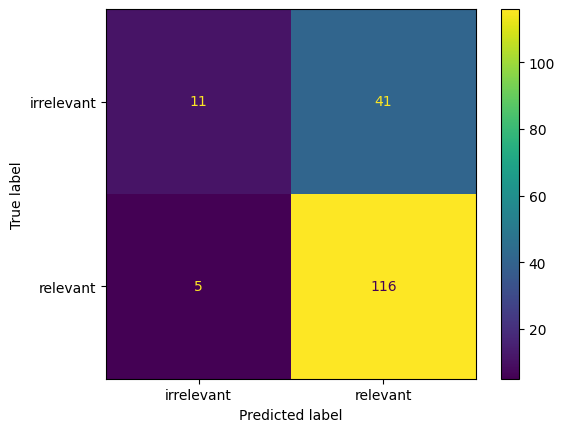

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")
# Map Author Labeling to binary classes
df['Author Labeling Binary'] = df['Author Labeling'].map({
    'irrelevant': 0,
    'refuting': 1,
    'supporting': 1
})

# Ensure there are no missing values in scores or labels
df = df.dropna(subset=['max_bge_ranker_score_new_val', 'Author Labeling Binary'])

# Sweep through thresholds to find the optimal one
thresholds = np.linspace(df['max_bge_ranker_score_new_val'].min(), df['max_bge_ranker_score_new_val'].max(), 100000)  # 100 thresholds between min and max score
min_misclassification = float('inf')
optimal_threshold = None

for threshold in thresholds:
    # Predict based on the threshold
    df['Predicted Label'] = (df['max_bge_ranker_score_new_val'] >= threshold).astype(int)

    # Calculate misclassification error
    misclassification = (df['Predicted Label'] != df['Author Labeling Binary']).sum()

    # Update optimal threshold
    if misclassification < min_misclassification:
        min_misclassification = misclassification
        optimal_threshold = threshold
df['Predicted Label'] = (df['max_bge_ranker_score_new_val'] >= optimal_threshold).astype(int)

# Print the optimal threshold and the corresponding misclassification error
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Minimum Misclassification: {min_misclassification}")

# Apply the optimal threshold to classify tweets
df['Final Classification'] = (df['max_bge_ranker_score_new_val'] >= optimal_threshold).map({0: 'irrelevant', 1: 'relevant'})

# Calculate Misclassification Rate
misclassification_rate = min_misclassification / len(df)
print(f"Misclassification Rate: {misclassification_rate:.4f}")

# Generate the Confusion Matrix
y_true = df['Author Labeling Binary']
y_pred = df['Predicted Label']
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['irrelevant', 'relevant']).plot()

# Save the results
#df.to_csv("classified_stance_results.csv", index=False)

# Display a sample of the classified DataFrame
print(df[['tweet_text', 'max_bge_ranker_score_new_val', 'Author Labeling', 'Final Classification']].head())

# BGE Ranker LLM

In [4]:
from FlagEmbedding import FlagLLMReranker
cache_dir = "./"
reranker = FlagLLMReranker('BAAI/bge-reranker-v2-gemma', use_fp16=True, cache_dir= cache_dir) # Setting use_fp16 to True speeds up computation with a slight performance degradation
# reranker = FlagLLMReranker('BAAI/bge-reranker-v2-gemma', use_bf16=True) # You can also set use_bf16=True to speed up computation with a slight performance degradation

score = reranker.compute_score(['query', 'passage'])
print(score)

scores = reranker.compute_score([['what is panda?', 'hi'], ['what is panda?', 'The giant panda (Ailuropoda melanoleuca), sometimes called a panda bear or simply panda, is a bear species endemic to China.']])
print(scores)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  9.68it/s]
You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 1/1 [00:00<00:00, 80.68it/s]


[1.958984375]


100%|██████████| 1/1 [00:00<00:00, 71.50it/s]

[-0.98095703125, 10.71875]


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")

# Function to compute the BGE ranker score
def compute_bge_score(query, passage):
    # Compute the score using reranker
    score = reranker.compute_score([query, passage])
    return score[0] if isinstance(score, list) else score

# Compute scores for 'fact'
df['bge_ranker_score_fact'] = df.apply(
    lambda row: compute_bge_score(row['fact'], row['tweet_text']), axis=1
)

# Compute scores for 'supporting'
df['bge_ranker_score_supporting'] = df.apply(
    lambda row: compute_bge_score(row['supporting'], row['tweet_text']), axis=1
)

# Compute scores for 'refuting'
df['bge_ranker_score_refuting'] = df.apply(
    lambda row: compute_bge_score(row['refuting'], row['tweet_text']), axis=1
)


df['max_bge_ranker_score_llm_new_val'] = df[
    ['bge_ranker_score_fact', 'bge_ranker_score_supporting', 'bge_ranker_score_refuting']
].max(axis=1)

# Save the updated DataFrame to a new CSV file
df.to_csv("updated_stance_results_with_bge_ranker_scores_llm.csv", index=False)

print("BGE ranker scores computed for 'fact', 'supporting', and 'refuting', and maximum score saved.")

In [ ]:
df = pd.read_csv("ann_dataset_misleading.csv")

# Function to compute the BGE ranker score
def compute_bge_score(query, passage):
    # Compute the score using reranker
    score = reranker.compute_score([query, passage])
    return score[0] if isinstance(score, list) else score

# Compute scores for 'fact'
df['bge_ranker_score_fact_llm'] = df.apply(
    lambda row: compute_bge_score(row['fact'], row['tweet_text']), axis=1
)
df.to_csv("updated_stance_results_with_bge_ranker_scores.csv", index=False)


Optimal Threshold: 3.865287791061504
Minimum Misclassification: 36
Misclassification Rate: 0.2081

Confusion Matrix:
[[ 33  19]
 [ 17 104]]
                                           tweet_text  \
3   See how Demos add fake voters in WI and MI. ??...   
4   For Biden, it is considered that at the moment...   
6   Look at democrats mysterious jump to win after...   
13  I still have not heard an explanation of this....   
17  Michigan manufactures Biden Ballots outrageous...   

    max_bge_ranker_score_llm_new_val Author Labeling Final Classification  
3                           7.953125        refuting                  NaN  
4                           6.585938        refuting                  NaN  
6                           4.542969        refuting                  NaN  
13                          6.164062        refuting                  NaN  
17                          6.375000        refuting                  NaN  


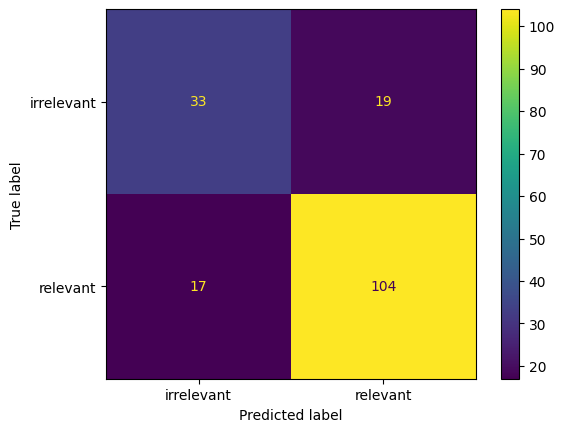

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")
# Map Author Labeling to binary classes
df['Author Labeling Binary'] = df['Author Labeling'].map({
    'irrelevant': 0,
    'refuting': 1,
    'supporting': 1
})

# Ensure there are no missing values in scores or labels
df = df.dropna(subset=['max_bge_ranker_score_llm_new_val', 'Author Labeling Binary'])

# Sweep through thresholds to find the optimal one
thresholds = np.linspace(df['max_bge_ranker_score_llm_new_val'].min(), df['max_bge_ranker_score_llm_new_val'].max(), 100000)  # 100 thresholds between min and max score
min_misclassification = float('inf')
optimal_threshold = None

for threshold in thresholds:
    # Predict based on the threshold
    df['Predicted Label'] = (df['max_bge_ranker_score_llm_new_val'] >= threshold).astype(int)

    # Calculate misclassification error
    misclassification = (df['Predicted Label'] != df['Author Labeling Binary']).sum()

    # Update optimal threshold
    if misclassification < min_misclassification:
        min_misclassification = misclassification
        optimal_threshold = threshold
df['Predicted Label'] = (df['max_bge_ranker_score_llm_new_val'] >= optimal_threshold).astype(int)

# Print the optimal threshold and the corresponding misclassification error
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Minimum Misclassification: {min_misclassification}")

# Apply the optimal threshold to classify tweets
df['Final Classification'] = (df['max_bge_ranker_score_llm_new_val'] >= optimal_threshold).map({0: 'irrelevant', 1: 'relevant'})

# Calculate Misclassification Rate
misclassification_rate = min_misclassification / len(df)
print(f"Misclassification Rate: {misclassification_rate:.4f}")

# Generate the Confusion Matrix
y_true = df['Author Labeling Binary']
y_pred = df['Predicted Label']
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['irrelevant', 'relevant']).plot()

# Save the results
#df.to_csv("classified_stance_results.csv", index=False)

# Display a sample of the classified DataFrame
print(df[['tweet_text', 'max_bge_ranker_score_llm_new_val', 'Author Labeling', 'Final Classification']].head())

# Stella Model-1.5B

In [4]:
cache_dir = "./"

import os
from transformers.utils import logging

os.environ["TRANSFORMERS_CACHE"] = "./"
logging.set_verbosity_info()

print(f"TRANSFORMERS_CACHE set to: {os.environ['TRANSFORMERS_CACHE']}")


TRANSFORMERS_CACHE set to: ./


In [ ]:
# Load the Stella model
import os
#os.environ["TRANSFORMERS_CACHE"] = "./"
os.environ['HF_HOME'] = "./"

from sentence_transformers import SentenceTransformer, util

# Change cache location
model = SentenceTransformer("dunzhang/stella_en_1.5B_v5", trust_remote_code=True).cuda()

# Queries and documents
query_prompt_name = "s2s_query"  # Sentence-to-passage query (not used directly in this example)
queries = [
    "What are some ways to reduce stress?",
    "What are the benefits of drinking green tea?",
]

# Documents (passage texts)
docs = [
    "There are many effective ways to reduce stress. Some common techniques include deep breathing, meditation, and physical activity. Engaging in hobbies, spending time in nature, and connecting with loved ones can also help alleviate stress. Additionally, setting boundaries, practicing self-care, and learning to say no can prevent stress from building up.",
    "Green tea has been consumed for centuries and is known for its potential health benefits. It contains antioxidants that may help protect the body against damage caused by free radicals. Regular consumption of green tea has been associated with improved heart health, enhanced cognitive function, and a reduced risk of certain types of cancer. The polyphenols in green tea may also have anti-inflammatory and weight loss properties.",
]

# Encode the queries and documents
query_embeddings = model.encode(queries, convert_to_tensor=True, normalize_embeddings=True)
doc_embeddings = model.encode(docs, convert_to_tensor=True, normalize_embeddings=True)

# Calculate cosine similarity between queries and documents
scores = util.cos_sim(query_embeddings, doc_embeddings)

# Print the results
for i, query in enumerate(queries):
    print(f"Query: {query}")
    for j, doc in enumerate(docs):
        print(f" - Document {j + 1}: Score: {scores[i][j].item():.4f}")

In [ ]:

query_prompt_name = "s2p_query"  # Sentence-to-passage query
queries = [ "The sudden jump in Joe Biden's votes in Michigan was due to a temporary data glitch, not fraud.",
"There is a map or graph that alleges Biden found 138,000+ votes overnight to overtake Trump in Michigan, and it's evidence of an election being stolen",
"Joe Biden did not mysteriously gain 138,000 Michigan votes all at once"
]

# Documents (no prompts needed for docs)
docs = [
       "2. Voter Fraud lawsuits - @DonaldJTrumpJr Team will be laser-focus on these: &gt;Limestone County already had 1 arrest &gt;PA has a UPS worker agreeing to testify in court that the supervisors were backdating &gt;Glitch in Michigan &gt;Pennsylvania/Georgia not allowing Republican observers",

]

# Encode the queries and documents
query_embeddings = model.encode(queries, convert_to_tensor=True, prompt_name=query_prompt_name, normalize_embeddings=True)
doc_embeddings = model.encode(docs, convert_to_tensor=True, normalize_embeddings=True)

# Calculate cosine similarity between queries and documents
scores = util.cos_sim(query_embeddings, doc_embeddings)
print(scores)
mean_score = scores.mean().item()
print(f"Mean Cosine Similarity: {mean_score:.4f}")


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util

# Assuming 'model' is already loaded
# model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True)

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")

# Function to compute scores for a given query type
def compute_scores(df, query_col, score_col_name):
    # Group rows by the query column (e.g., 'fact') and collect corresponding tweets
    grouped = df.groupby(query_col)['text'].apply(list).reset_index()
    grouped.columns = [query_col, 'documents']

    # Prepare a list to store the results
    results_list = []
    query_prompt_name = "s2p_query"  # Sentence-to-passage query

    # Iterate over each query and its associated documents
    for _, row in grouped.iterrows():
        query = row[query_col]  # Query (e.g., fact, supporting, or refuting)
        documents = row['documents']  # List of tweets

        # Encode the query and documents
        query_embeddings = model.encode(query, convert_to_tensor=True, prompt_name=query_prompt_name, normalize_embeddings=True)
        doc_embeddings = model.encode(documents, convert_to_tensor=True, normalize_embeddings=True)

        # Calculate cosine similarity between the query and documents
        scores = util.cos_sim(query_embeddings, doc_embeddings)

        # Map the scores back to the original DataFrame rows
        for idx, score in enumerate(scores[0]):  # Loop through document scores
            results_list.append({
                query_col: query,
                'text': documents[idx],  # Corresponding tweet
                score_col_name: round(score.item(), 4)  # Convert tensor to Python float
            })

    # Convert results into a DataFrame
    return pd.DataFrame(results_list)

# Compute scores for 'fact', 'supporting', and 'refuting'
final_df = compute_scores(df, 'image_exp_internvl2', 'score_stella_relevancy')
#results_df_supporting = compute_scores(df, 'supporting', 'score_stella_supporting')
#results_df_refuting = compute_scores(df, 'refuting', 'score_stella_refuting')

# Merge the results DataFrames on 'tweet_text'
#merged_df = pd.merge(results_df_fact, results_df_supporting, on="tweet_text", how="outer")
#merged_df = pd.merge(merged_df, results_df_refuting, on="tweet_text", how="outer")

# Take the minimum score across all score columns
#merged_df["min_score_stella"] = merged_df[
#    ["score_stella_fact", "score_stella_supporting", "score_stella_refuting"]
#].mean(axis=1)

# Create a new DataFrame with only the necessary columns
#results_df_min = merged_df[["tweet_text", "min_score_stella"]]


# Merge the original DataFrame with the scores DataFrame on 'tweet_text'
final_df = pd.merge(df, final_df, on=['text','image_exp_internvl2'], how='left')

# Save the updated DataFrame to a new CSV
final_df.to_csv("updated_file2.csv", index=False)

# Print a sample of the updated DataFrame
print(final_df.head())

                                    image_path  \
0    CLIP-Dataset/Image Annotation/story_2.jpg   
1  CLIP-Dataset/Image Annotation/story_648.jpg   
2   CLIP-Dataset/Image Annotation/story_28.jpg   
3    CLIP-Dataset/Image Annotation/story_2.jpg   
4  CLIP-Dataset/Image Annotation/story_648.jpg   

                                                text     label  \
0  See how Demos add fake voters in WI and MI. ??...  refuting   
1  See how Demos add fake voters in WI and MI. ??...  refuting   
2  See how Demos add fake voters in WI and MI. ??...  refuting   
3  For Biden, it is considered that at the moment...  refuting   
4  For Biden, it is considered that at the moment...  refuting   

   stance_llama_vision  qwen_model  internvl2_model  \
0                    1           0                0   
1                    1           0                1   
2                    1           0                0   
3                    0           0                1   
4                    0     

# Stella Model-400M

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util

# Assuming 'model' is already loaded
model = SentenceTransformer(
    "dunzhang/stella_en_400M_v5",
    trust_remote_code=True)
# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")

# Function to compute scores for a given query type
def compute_scores(df, query_col, score_col_name):
    # Group rows by the query column (e.g., 'fact') and collect corresponding tweets
    grouped = df.groupby(query_col)['tweet_text'].apply(list).reset_index()
    grouped.columns = [query_col, 'documents']

    # Prepare a list to store the results
    results_list = []
    query_prompt_name = "s2p_query"  # Sentence-to-passage query

    # Iterate over each query and its associated documents
    for _, row in grouped.iterrows():
        query = row[query_col]  # Query (e.g., fact, supporting, or refuting)
        documents = row['documents']  # List of tweets

        # Encode the query and documents
        query_embeddings = model.encode(query, convert_to_tensor=True, prompt_name=query_prompt_name, normalize_embeddings=True)
        doc_embeddings = model.encode(documents, convert_to_tensor=True, normalize_embeddings=True)

        # Calculate cosine similarity between the query and documents
        scores = util.cos_sim(query_embeddings, doc_embeddings)

        # Map the scores back to the original DataFrame rows
        for idx, score in enumerate(scores[0]):  # Loop through document scores
            results_list.append({
                query_col: query,
                'tweet_text': documents[idx],  # Corresponding tweet
                score_col_name: round(score.item(), 4)  # Convert tensor to Python float
            })

    # Convert results into a DataFrame
    return pd.DataFrame(results_list)

# Compute scores for 'fact', 'supporting', and 'refuting'
results_df_fact = compute_scores(df, 'fact', 'score_stella_fact')
results_df_supporting = compute_scores(df, 'supporting', 'score_stella_supporting')
results_df_refuting = compute_scores(df, 'refuting', 'score_stella_refuting')

# Merge the results DataFrames on 'tweet_text'
merged_df = pd.merge(results_df_fact, results_df_supporting, on="tweet_text", how="outer")
merged_df = pd.merge(merged_df, results_df_refuting, on="tweet_text", how="outer")

# Take the minimum score across all score columns
merged_df["max_score_stella"] = merged_df[
    ["score_stella_fact", "score_stella_supporting", "score_stella_refuting"]
].max(axis=1)

# Create a new DataFrame with only the necessary columns
results_df_max = merged_df[["tweet_text", "max_score_stella"]]

# Merge the original DataFrame with the scores DataFrame on 'tweet_text'
final_df = pd.merge(df, results_df_max, on='tweet_text', how='left')

# Save the updated DataFrame to a new CSV
final_df.to_csv("updated_stance_results_with_stella_scores_max.csv", index=False)

# Print a sample of the updated DataFrame
print(final_df.head())

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util

# Assuming 'model' is already loaded
# model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True)

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")

# Function to compute scores for a given query type
def compute_scores(df, query_col, score_col_name):
    # Group rows by the query column (e.g., 'fact') and collect corresponding tweets
    grouped = df.groupby(query_col)['tweet_text'].apply(list).reset_index()
    grouped.columns = [query_col, 'documents']

    # Prepare a list to store the results
    results_list = []
    query_prompt_name = "s2p_query"  # Sentence-to-passage query

    # Iterate over each query and its associated documents
    for _, row in grouped.iterrows():
        query = row[query_col]  # Query (e.g., fact, supporting, or refuting)
        documents = row['documents']  # List of tweets

        # Encode the query and documents
        query_embeddings = model.encode(query, convert_to_tensor=True, prompt_name=query_prompt_name, normalize_embeddings=True)
        doc_embeddings = model.encode(documents, convert_to_tensor=True, normalize_embeddings=True)

        # Calculate cosine similarity between the query and documents
        scores = util.cos_sim(query_embeddings, doc_embeddings)

        # Map the scores back to the original DataFrame rows
        for idx, score in enumerate(scores[0]):  # Loop through document scores
            results_list.append({
                query_col: query,
                'tweet_text': documents[idx],  # Corresponding tweet
                score_col_name: round(score.item(), 4)  # Convert tensor to Python float
            })

    # Convert results into a DataFrame
    return pd.DataFrame(results_list)

# Compute scores for 'fact', 'supporting', and 'refuting'
results_df_fact = compute_scores(df, 'fact', 'score_stella_fact')
results_df_supporting = compute_scores(df, 'supporting', 'score_stella_supporting')
results_df_refuting = compute_scores(df, 'refuting', 'score_stella_refuting')

# Merge the results DataFrames on 'tweet_text'
merged_df = pd.merge(results_df_fact, results_df_supporting, on="tweet_text", how="outer")
merged_df = pd.merge(merged_df, results_df_refuting, on="tweet_text", how="outer")

# Take the minimum score across all score columns
merged_df["min_score_stella"] = merged_df[
    ["score_stella_fact", "score_stella_supporting", "score_stella_refuting"]
].mean(axis=1)

# Create a new DataFrame with only the necessary columns
results_df_min = merged_df[["tweet_text", "min_score_stella"]]


# Merge the original DataFrame with the scores DataFrame on 'tweet_text'
final_df = pd.merge(df, results_df_min, on='tweet_text', how='left')

# Save the updated DataFrame to a new CSV
final_df.to_csv("updated_stance_results_with_stella_scores_min.csv", index=False)

# Print a sample of the updated DataFrame
print(final_df.head())

                                          tweet_text  \
0  I'm not sure voter malpractice occurred, but a...   
1  Although I believe trump will lose the electio...   
2  Michigan - Biden votes came out of nowhere fro...   
3  See how Demos add fake voters in WI and MI. ??...   
4  For Biden, it is considered that at the moment...   

  is tweet-image pair relevant? Author Labeling Author Labeling 2  \
0                           NaN             NaN               NaN   
1                           NaN             NaN               NaN   
2                           NaN             NaN               NaN   
3                      positive        refuting          refuting   
4                      positive        refuting          refuting   

  Author Labeling 3         storyid  \
0               NaN  story_2+648+28   
1               NaN  story_2+648+28   
2               NaN  story_2+648+28   
3          refuting  story_2+648+28   
4          refuting  story_2+648+28   

             

In [52]:
df = pd.read_csv("updated_stance_results_with_stella_scores_p.csv")
df.rename(columns={"score_stella_y": "score_stella_p"}, inplace=True)
df.rename(columns={"score_stella_x": "score_stella_s"}, inplace=True)
df.to_csv("updated_stance_results_with_stella_scores_sp.csv", index=False)


In [2]:
import pandas as pd
df = pd.read_csv("last_dataset_with_colbert_scores_4.csv")
optimal_threshold =  0.5237686543532102
df['Stella Predicted Label'] = (df['max_score_stella_new_val'] >= optimal_threshold).astype(int)
df.to_csv("last_dataset_with_colbert_scores_4.csv", index=False)


Threshold | Precision | Recall | Accuracy | F1-score
--------------------------------------------------

Best Threshold Found:
Optimal Threshold: 0.99951
Best Precision: 0.6358
Best Recall: 1.0000
Best Accuracy: 0.6358
Best F1-score: 0.7774

Confusion Matrix:
[[  0  63]
 [  0 110]]

Sample of Classified Data:
    max_similarity_score_llama_2  Author Labeling Binary  Predicted Label  \
3                            1.0                     1.0                1   
4                            1.0                     1.0                1   
6                            1.0                     1.0                1   
13                           1.0                     1.0                1   
17                           1.0                     1.0                1   

   Final Classification  
3              relevant  
4              relevant  
6              relevant  
13             relevant  
17             relevant  


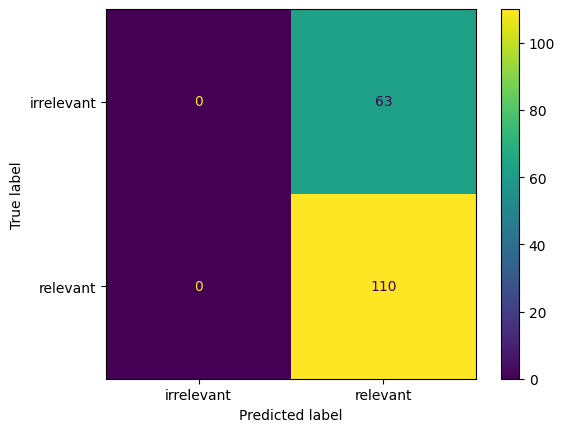

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support, accuracy_score, ConfusionMatrixDisplay
)

# Load the dataset
df = pd.read_csv("ann_dataset_misleading.csv")

# Map labels to binary classes
df['Author Labeling Binary'] = df['Final Labeling'].map({
    'irrelevant': 0,
    'refuting': 1,
    'supporting': 1
})

# Remove NaN values in relevant columns
df = df.dropna(subset=['max_similarity_score_llama_2', 'Author Labeling Binary'])

# Sweep through thresholds to find the best one based on F1-score
thresholds = np.linspace(df['max_similarity_score_llama_2'].min(), df['max_similarity_score_llama_2'].max(), 500)
best_threshold = None
best_f1 = -1  # Initialize with a low F1-score
best_metrics = {}
best_accuracy = -1  # Initialize with a low F1-score

print("Threshold | Precision | Recall | Accuracy | F1-score")
print("-" * 50)

for threshold in thresholds:
    # Predict labels based on the threshold
    df['Predicted Label'] = (df['max_similarity_score_llama_2'] >= threshold).astype(int)

    # Compute precision, recall, F1-score, and accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(
        df['Author Labeling Binary'], df['Predicted Label'], average='binary'
    )
    accuracy = accuracy_score(df['Author Labeling Binary'], df['Predicted Label'])

    # Print the metrics for each threshold
   # print(f"{threshold:.5f} | {precision:.4f} | {recall:.4f} | {accuracy:.4f} | {f1:.4f}")

    # Update best threshold if F1-score is improved
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_metrics = {
            "Precision": precision,
            "Recall": recall,
            "Accuracy": accuracy,
            "F1-score": f1
        }

# Apply the best threshold for final classification
df['Predicted Label'] = (df['max_similarity_score_llama_2'] >= best_threshold).astype(int)
df['Final Classification'] = df['Predicted Label'].map({0: 'irrelevant', 1: 'relevant'})

# Print the best threshold and its metrics
print("\nBest Threshold Found:")
print(f"Optimal Threshold: {best_threshold:.5f}")
print(f"Best Precision: {best_metrics['Precision']:.4f}")
print(f"Best Recall: {best_metrics['Recall']:.4f}")
print(f"Best Accuracy: {best_metrics['Accuracy']:.4f}")
print(f"Best F1-score: {best_metrics['F1-score']:.4f}")

# Generate and print the Confusion Matrix
y_true = df['Author Labeling Binary']
y_pred = df['Predicted Label']
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['irrelevant', 'relevant']).plot()

# Save the results
#df.to_csv("classified_stance_results_temp_2.csv", index=False)

# Display a sample of the classified DataFrame
print("\nSample of Classified Data:")
print(df[['max_similarity_score_llama_2', 'Author Labeling Binary', 'Predicted Label', 'Final Classification']].head())

# Colbertv2.0

In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv('ann_dataset_misleading.csv')

# Limit to the first 242 rows
subset_df = df.iloc[:242]

# Save tweets to collection.tsv
with open('collection.tsv', 'w') as f:
    for idx, tweet in enumerate(subset_df['tweet_text']):
        f.write(f"{idx}\t{tweet}\n")

# Save facts to queries.tsv
with open('queries.tsv', 'w') as f:
    for idx, query in enumerate(subset_df['fact']):
        f.write(f"{idx}\t{query}\n")

In [ ]:
from colbert import ColBERT

from colbert.indexing import Indexer

# Load the pre-trained ColBERT model
colbert = ColBERT.from_pretrained('colbert-ir/colbertv2.0')

# Index the collection
indexer = Indexer(colbert, collection_path='collection.tsv', index_path='index/')
indexer.index()

from colbert.search import Searcher

# Initialize the searcher
searcher = Searcher(index_path='index/', colbert=colbert)

# Query the indexed data
queries = pd.read_csv('queries.tsv', sep='\t', header=None, names=['id', 'query'])
for _, row in queries.iterrows():
    query_id, query_text = row['id'], row['query']
    results = searcher.search(query_text, k=len(unique_queries))
    print(f"Query: {query_text}")
    for passage_id, score in results:
        print(f"  Tweet ID: {passage_id}, Score: {score}")

# Measure of agreement between two dependent categorical samples

## Cohen's Kappa

In [ ]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Load your dataset
df = pd.read_csv("baselines_for_part_a_dataset.json")

df = df[df['Author Labeling 3'].notna() & (df['Author Labeling'] != '')]
print(len(df))
# Ensure the two annotator columns are present
if 'Author Labeling' not in df.columns or 'Author Labeling 3' not in df.columns:
    raise ValueError("The columns 'Author Labeling' and 'Author Labeling 1' must be present in the dataset.")
# Drop rows where either annotator has missing labels
df = df.dropna(subset=['Author Labeling', 'Author Labeling 3'])

# Map the labels to numeric values if they are categorical
# Example mapping: {'irrelevant': 0, 'supporting': 1, 'refuting': 2}
label_mapping = {'irrelevant': 0, 'supporting': 1, 'refuting': 2}
df['Annotator 1'] = df['Author Labeling'].map(label_mapping)
df['Annotator 2'] = df['Author Labeling 3'].map(label_mapping)
print(df['Annotator 2'])
df = df.dropna(subset=['Annotator 1', 'Annotator 2'])
print(len(df))
# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(df['Annotator 1'], df['Annotator 2'])

# Print the result
print(f"Cohen's kappa score: {kappa_score:.4f}")

173
0      2
1      2
2      2
3      2
4      2
      ..
168    0
169    0
170    2
171    2
172    0
Name: Annotator 2, Length: 173, dtype: int64
173
Cohen's kappa score: 0.8459


# QWEN Model

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# Assuming you want to use the second GPU (index 1)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
inputs = inputs.to(device)

# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype=torch.bfloat16, device_map="auto", cache_dir = './', token = hf_token
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-72B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-72B-Instruct", use_fast =True ,cache_dir = './', token =hf_token)

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-72B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

# Prepare the input prompt
def prepare_prompt(row):
    return f"""
      You will be provided with a tweet text and the image. Indicate if the tweet text is relevant or irrelevant to the given image. 
        Only respond with one of the following words: [relevant, irrelevant]. Do not provide any explanations or additional information.
        Tweet Text: {row['text']}"""
# Generate stance for each row
def get_stance(row):
    print(f"Processing index: {row.name}")  # Print the index of the current row
    input_text = prepare_prompt(row)
    image_path = row["image_path"]
    image = Image.open(image_path).convert("RGB")
    messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": input_text}
    ]}
    ]
    messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {"type": "text", "text": input_text},
        ],
    }
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(device)
    generated_ids = model.generate(**inputs, max_new_tokens=30)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    print(output_text)

    return output_text
csv_path = "ann_dataset_misleading.csv"  # Replace with your CSV file path
image_folder = "CLIP-Dataset/Image Annotation/"  # Image folder path

# Read CSV
df = pd.read_csv(csv_path)
# Apply stance generation function to the entire DataFrame
df["stance_qwen_model"] = df.apply(get_stance, axis=1)

# Save the entire DataFrame to one CSV
#df.to_csv("final_results_pipeline_2.csv", index=False)
print("All results saved to final_results.csv")


# InternVL2_5-38B-MPO for OOC and Benign Images Dataset

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import requests
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor
import pandas as pd
import math
import numpy as np
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

path = "OpenGVLab/InternVL2_5-38B-MPO"

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

def split_model(model_name):
    device_map = {}
    world_size = torch.cuda.device_count()
    num_layers = {
        'InternVL2_5-1B': 24, 'InternVL2_5-2B': 24, 'InternVL2_5-4B': 36, 'InternVL2_5-8B': 32,
        'InternVL2_5-26B': 48, 'InternVL2_5-38B': 64, 'InternVL2_5-78B': 80}[model_name]
    # Since the first GPU will be used for ViT, treat it as half a GPU.
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for j in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.model.rotary_emb'] = 0
    device_map['language_model.lm_head'] = 0
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0

    return device_map

# If you set `load_in_8bit=True`, you will need one 80GB GPUs.
# If you set `load_in_8bit=False`, you will need at least two 80GB GPUs.
path = 'OpenGVLab/InternVL2_5-38B-MPO'
device_map = split_model('InternVL2_5-38B')
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    load_in_8bit=False,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True,
    cache_dir = './venvs/',
    device_map=device_map).eval()
tokenizer = AutoTokenizer.from_pretrained(path, cache_dir= './venvs/', trust_remote_code=True, use_fast=False)
'''
import math
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

def split_model(model_name):
    device_map = {}
    world_size = torch.cuda.device_count()
    num_layers = {
        'InternVL2_5-1B': 24, 'InternVL2_5-2B': 24, 'InternVL2_5-4B': 36, 'InternVL2_5-8B': 32,
        'InternVL2_5-26B': 48, 'InternVL2_5-38B': 64, 'InternVL2_5-78B': 80}[model_name]
    # Since the first GPU will be used for ViT, treat it as half a GPU.
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for j in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.model.rotary_emb'] = 0
    device_map['language_model.lm_head'] = 0
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0

    return device_map

# If you set `load_in_8bit=True`, you will need two 80GB GPUs.
# If you set `load_in_8bit=False`, you will need at least three 80GB GPUs.
path = 'OpenGVLab/InternVL2_5-78B-MPO'
device_map = split_model('InternVL2_5-78B')
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    load_in_8bit=True,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True,
    device_map=device_map,
    cache_dir = './venvs/').eval()
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False, cache_dir='./venvs/')


# Prepare the input prompt
def prepare_prompt(row):
    return f"""
      You will be provided a tweet and the explanation of tweets image pair. Indicate if the tweet text is relevant or irrelevant to the given image explanation.
      If the tweet text doesnt have any explanation about the image or the text is slightly relevant to the image, please classify it as irrelevant.
      Only respond with one of the following words: [relevant, irrelevant]. Do not provide any explanations or additional information.
    Tweet Text: {row['text']}
    Image Explanation: {row['image_exp_internvl2']}"""
# Generate stance for each row
def get_stance(row):
    print(f"Processing index: {row.name}")  # Print the index of the current row
    input_text = prepare_prompt(row)
    image_path = row["image_path"]
    # set the max number of tiles in `max_num`
    pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=1024, do_sample=False)
    
    
    # pure-text conversation (纯文本对话)
    question = 'Hello, who are you?'
    response, history = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)
    print(f'User: {question}\nAssistant: {response}')
    
    
    
    # single-image single-round conversation (单图单轮对话)
    question = f'<image>\n{input_text}'
    #question = f'{input_text}'

    response = model.chat(tokenizer, pixel_values,  question, generation_config)
    print(f'User: {question}\nAssistant:{response}')

    return response

# Load dataset


# single-image multi-round conversation (单图多轮对话)
question = '<image>\nPlease describe the image in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

question = 'Please write a poem according to the image.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')
'''
'''
# multi-image multi-round conversation, combined images (多图多轮对话，拼接图像)
pixel_values1 = load_image('./examples/image1.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('./examples/image2.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)

question = '<image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=None, return_history=True)
print(f'User: {queston}\nAssistant: {response}')

question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

# multi-image multi-round conversation, separate images (多图多轮对话，独立图像)
pixel_values1 = load_image('./examples/image1.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('./examples/image2.jpg', max_num=12).
to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0)]

question = 'Image-1: <image>\nImage-2: <image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')
'''



# Our Dataset

In [ ]:
#### import csv
import os
import json
from google.cloud import vision
import imagehash 
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import logging
from newspaper import Article
import nltk

def are_images_similar(local_path, content_url, hash_type='phash', threshold=5):
    try:
        local_img = Image.open(local_path).convert("RGB")

        headers = {
            "User-Agent": "Mozilla/5.0"
        }
        response = requests.get(content_url, headers=headers)
        response.raise_for_status()
        imgur_img = Image.open(BytesIO(response.content)).convert("RGB")

        hash_func = getattr(imagehash, hash_type)
        hash_local = hash_func(local_img)
        hash_imgur = hash_func(imgur_img)

        difference = hash_local - hash_imgur
        return difference <= threshold, difference
    
    except requests.exceptions.HTTPError as e:
        print(f"⚠️ HTTPError for URL: {content_url} → {e}")
        return False, None

    except Exception as e:
        print(f"⚠️ Error comparing images: {e}")

        return False, None

question = """<image>
### Context
You are provided with:
- An image
- A tweet written by a user

Your task is to analyze how the tweet text relates to the image and determine the type of relationship or miscaptioning it might represent.

### Definitions

1. **Narrative-Based Miscaptioning**:  
   The image supports the topic of the tweet, but the **text exaggerates or extends the meaning** by adding claims or context not evident from the image itself. These are often unverifiable, interpretive, or political.

2. **Evidence-Based Miscaptioning**:  
   The tweet **describes the image incorrectly**, such as misstating the **location, time, people, or objects**. The image is reused out of its original context, and this **factual mismatch can be verified**.

3. **None of them**:  
   The tweet **accurately refers to the image**, supports or comments on it **without changing its meaning**, and does **not introduce any false or unverifiable information**.

4. **Asymmetric**:  
   The tweet and image are **not meaningfully related**. The image does **not support or contradict the claim** in the text. Their contributions are disconnected, and no direct relationship can be drawn.

### Decision Process

- First, ask: **Does the image support or illustrate the tweet text?**
  - If **Yes**, consider:  
    - Is it adding unverifiable narratives? → **Narrative-Based**  
    - Is it factually wrong or out of context? → **Evidence-Based**  
    - Is it accurate and benign? → **None of them**
  - If **No**, label it as → **Asymmetric**

### Response Format

Respond with:
1. **One of the four labels**: Narrative-Based Miscaptioning, Evidence-Based Miscaptioning, None of them, or Asymmetric  
2. A brief reasoning (2–4 sentences) explaining your classification based on the image and tweet content.
"""

question3 = """<image>
### Context
You are provided with:
- An image
- A tweet written by a user

Your task is to assess whether the image supports, illustrates, or is meaningfully connected to the claim or main message in the tweet text.

### Question
Is the image related to the claim in the tweet text?

### Response Format
Respond with:
1. **Yes** or **No**
2. A short reasoning (2–4 sentences) explaining why you chose this answer, based on the content of the image and the claim in the tweet.
"""
        
question2 = """<image>
###Context
You are provided with:
	•	An image
	•	A tweet written by a user

Your task is to assess the relationship between the image and the tweet text, considering both:
	1.	The visual content of the image

###Classification
Classify the relationship into one of the following four categories:
	•	parallel:
The image and text independently contribute to the same or a very similar meaning without modifying each other.
	•	additive:
The image and text amplify or modify each other’s meanings, providing additional context, nuance, or emotional depth when combined.
	•	divergent:
The image and text meanings pull in opposite directions, contradict, or create a gap between the visual and textual suggestions.

###Response Format
Respond with:
	1.	One of the three labels:  parallel, additive, or divergent
	2.	A reasoning (2–4 sentences) explaining why you made this classification based on the visual and web entity information.
"""

# Open CSV file for writing
#image_content_df['intern_vl2_response_title'] = ''
i = 0
b=0 

def fetch_article_content(url):
    nltk.download('punkt_tab')
    try:
        article = Article(url)
        article.download()
        article.parse()

        # Optional NLP (for keywords & summary)
        article.nlp()

        print(f"Keywords: {article.keywords}")

        return article.keywords 

    except Exception as e:
        logging.error(f"Error fetching article from {url}: {e}")
        return ''

def detect_news_links(image_path):
    """Detects web-related information about an image and fetches relevant news articles."""
    client = vision.ImageAnnotatorClient()

    # Read the image
    with open(image_path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # Perform web detection
    response = client.web_detection(image=image)
    web_detection = response.web_detection


    web_entities = []
          
    if web_detection.web_entities:
        print("\n{} Web entities found: ".format(len(web_detection.web_entities)))
        for entity in web_detection.web_entities:
            print(f"\n\tScore      : {entity.score}")
            print(f"\tDescription: {entity.description}")
            web_entities.append(entity.description)

    return web_entities

from collections import OrderedDict

def main():   
    updated_tweets = []

    # Suppose 'tweet_dict' is your loaded JSON object (a dictionary)
    with open('twitter_dataset/filtered_sampled_tweets.json', 'r') as f:
        tweet_list = json.load(f)

    # Reconstruct the dictionary with the new key after 'raw_img'
    new_dict = OrderedDict()
    i = 0

    for tweet in tweet_list:
        new_tweet = OrderedDict()
    
        # Extract the fields
        raw_img = tweet.get('raw_img', '')
        image_path = 'twitter_dataset/filtered_images/' + raw_img
        if not os.path.exists(image_path):
            print(f"[SKIP] Image not found: {image_path}")
            continue  # Skip to next tweet
        #web_entities = detect_news_links(image_path)
        full_text = tweet.get('full_text', '')
        prompt = f"{question}\nUser Tweet:{full_text}\nAnswer:"
        pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()
        generation_config = dict(max_new_tokens=256, do_sample=False)
         # Generate model response
        response = model.chat(tokenizer, pixel_values, prompt, generation_config)
        
        print(f'id : {i}, full text: {full_text}, \n image_path: {image_path}')
        print(f'User: {prompt}\nAssistant: {response}')
        i = i+1  
        for key in tweet:
            new_tweet[key] = tweet[key]
            if key == 'raw_img':
                new_tweet['internvl_38_web_entities_response_reasoning_2'] = response
        updated_tweets.append(new_tweet)
    with open("twitter_dataset/updated_filtered_tweets_step_2.json", "w") as f:
            json.dump(updated_tweets, f, indent=4)
    
if __name__ == "__main__":
    main()
    

# Internvl OOC

In [ ]:
#### import csv
import os
import json
from google.cloud import vision
import imagehash
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import logging
from newspaper import Article
import nltk

def are_images_similar(local_path, content_url, hash_type='phash', threshold=5):
    try:
        local_img = Image.open(local_path).convert("RGB")

        headers = {
            "User-Agent": "Mozilla/5.0"
        }
        response = requests.get(content_url, headers=headers)
        response.raise_for_status()
        imgur_img = Image.open(BytesIO(response.content)).convert("RGB")

        hash_func = getattr(imagehash, hash_type)
        hash_local = hash_func(local_img)
        hash_imgur = hash_func(imgur_img)

        difference = hash_local - hash_imgur
        return difference <= threshold, difference
    
    except requests.exceptions.HTTPError as e:
        print(f"⚠️ HTTPError for URL: {content_url} → {e}")
        return False, None

    except Exception as e:
        print(f"⚠️ Error comparing images: {e}")
        return False, None
        
question = """<image>
## Context ##
You are provided with:
- An image
- A caption written by users  

Your task is to assess whether the caption is relevant the image or is out of context considering the given visual
Determine if the caption is used in context with the image.

## Response Format ##
Respond with **only one** of the following words, without any explanation:  
- out of context
- not out of context
"""
image_dir = "./sample_300_merged_balanced/"

# Open CSV file for writing
#image_content_df['intern_vl2_response_title'] = ''
i = 0
b=0 
csv_file = 'image_caption_analysis_intern_vl_78_2_3_vision.csv'
df = pd.read_csv(csv_file)
def fetch_article_content(url):
    nltk.download('punkt_tab')
    try:
        article = Article(url)
        article.download()
        article.parse()

        # Optional NLP (for keywords & summary)
        article.nlp()

        print(f"Keywords: {article.keywords}")

        return article.keywords 

    except Exception as e:
        logging.error(f"Error fetching article from {url}: {e}")
        return ''

def detect_news_links(image_path):
    """Detects web-related information about an image and fetches relevant news articles."""
    client = vision.ImageAnnotatorClient()

    # Read the image
    with open(image_path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # Perform web detection
    response = client.web_detection(image=image)
    web_detection = response.web_detection

    web_entities = []
          
    if web_detection.web_entities:
        print("\n{} Web entities found: ".format(len(web_detection.web_entities)))
        for entity in web_detection.web_entities:
            print(f"\n\tScore      : {entity.score}")
            print(f"\tDescription: {entity.description}")
            web_entities.append(entity.description)

    return web_entities
    
for index1, row in df.iterrows():

                caption = row["Caption"]
                image_path = row["Image Path"]
                #image_url = row["Image URL"]
                summary = "" if pd.isna(row["News Content Vision"]) else row["News Content Vision"]
                news_url = row['Content URL Vision']
                #keywords = "" if pd.isna(news_url) else fetch_article_content(news_url)

                '''
                if not pd.isna(image_url) :
                    is_similar, score = are_images_similar(image_path, image_url)
                    print(score)
                    if is_similar:
                        title = "" if pd.isna(row["Title"]) else row["Title"]
                        keywords =  "" if pd.isna(row["Content Keywords"]) else row["Content Keywords"]
                    else:
                        title = ""
                        keywords = ""
                else:
                    title = ""
                    keywords = ""
                '''
                print(image_path)
                #news_links = detect_news_links(image_path)
                prompt = f"{question}\nCaption:{caption}\nAnswer:"
                # Process image with the model
                
                #print(processor.decode(output[0]))
                # Decode model output
                #response = processor.decode(output[0], skip_special_tokens=True)
                #response = response.partition("assistant")[2].strip().lower()
                pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()
                generation_config = dict(max_new_tokens=256, do_sample=False)
                falsified = row['falsified_label']
                # Generate model response
                response = model.chat(tokenizer, pixel_values, prompt, generation_config)
                df.at[index1, 'internvl_38_vision_response'] = response

                print(f'id : {i}, caption: {caption}, \n image_path: {image_path} \n falsified: {falsified}')
                print(f'User: {prompt}\nAssistant: {response}')
                i = i+1

output_csv = 'image_caption_analysis_intern_vl_78_2_3_vision.csv'
df.to_csv(output_csv, index =False)
                            

In [3]:

import json
import os
import csv
from google.cloud import vision
import logging

json_path = "./sample_300_merged_balanced/sampled_annotations.json"  # Adjust path as needed
with open(json_path, "r") as f:
    data = json.load(f)

# Path to JSON annotation file
json_path = "./sample_300_merged_balanced/sampled_annotations.json"
image_dir = "./sample_300_merged_balanced/"
output_csv = "merged_balanced_url_path_with_summarized_content_title_labels2.csv"

'''
json_path = "./sample_300_scene/sampled_annotations.json"  # Adjust path as needed
with open(json_path, "r") as f:
    data = json.load(f)

# Path to JSON annotation file
json_path = "./sample_300_scene/sampled_annotations.json"
image_dir = "./sample_300_scene/images/"
output_csv = "image_caption_scene_api_descriptions_with_content.csv"
'''

from google.cloud import vision
import os
import requests
from bs4 import BeautifulSoup

# Set credentials for Google Cloud Vision API
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./tidal-skill-452922-r9-8937cb4e49e5.json"
# Trusted news sources
# Expanded Trusted News Sources List
TRUSTED_SOURCES = [
    "bbc.com", "bbc.co.uk",
    "theguardian.com",
    "washingtonpost.com",
    "usatoday.com",
    "reuters.com",
    "nytimes.com",
    "cnn.com",
    "npr.org",
    "apnews.com",
    "forbes.com",
    "bloomberg.com",
    "theatlantic.com",
    "economist.com"
]
def detect_news_links(image_path):
    """Detects web-related information about an image and fetches relevant news articles."""
    client = vision.ImageAnnotatorClient()

    # Read the image
    with open(image_path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # Perform web detection
    response = client.web_detection(image=image)
    web_detection = response.web_detection


    web_entities = []
          
    if web_detection.web_entities:
        print("\n{} Web entities found: ".format(len(web_detection.web_entities)))
        for entity in web_detection.web_entities:
            print(f"\n\tScore      : {entity.score}")
            print(f"\tDescription: {entity.description}")
            web_entities.append(entity.description)

    return web_entities
    
def summarize_content(content):
        prompt = f"Give me the summarized version of this news content: {content}\n\nAnswer:"

        generation_config = dict(max_new_tokens=256, do_sample=False)
        response = model.chat(tokenizer, None, prompt, generation_config)
        return response
question = """<image>
## Context ##
You are provided with:
- An image
- A caption written by users  

Your task is to assess whether the caption is relevant the image or is out of context considering the given visual 
## Objective ##
Determine if the caption is used in context with the image.

## Response Format ##
Respond with **only one** of the following words, without any explanation:  
- out of context
- not out of context
"""
image_content_df = pd.read_csv('image_caption_analysis_merged_balanced_api_description.csv')
# Open CSV file for writing
#image_content_df['intern_vl2_response_title'] = ''
i = 0
b=0 
    # Iterate over each annotation
for  ann in data["annotations"]:
        caption = ann["caption"]
        image_path = os.path.join(image_dir, ann["image_path"] + ".jpg")
        original_image_path = '/Users/mirayrdm/Documents/Courses/Research/sample_300_merged_balanced/images/' + image_path[29:]
        if not os.path.exists(image_path):
            print(f"Warning: Image not found at {image_path}")
            b = b+1
            continue  # Skip missing images
        # Example Usage
        news_links = []
        print(original_image_path)
        # Check if the value exists in the DataFrame
        matching_row = image_content_df[image_content_df["Original Path"] == original_image_path]
        news_content = ''
        keywords = ''
        if not matching_row.empty:
            news_content = matching_row["Title"].values[0]  
            #keywords = matching_row['Content Keywords'].values[0]
            if not isinstance(news_content, float) or not pd.isna(news_content):  # Ensure it's not NaN
                if len(news_content) != 0:  # Check if content exists
                    summarized_content = news_content
                else:
                    summarized_content = ''
            else:
                summarized_content = ''
        else:
            print("⚠ No matching 'Original Path' found.")
            
        #news_links = detect_news_links(image_path)
    
        # Construct the prompt
        #question = "<image>Does the caption accurately describe the content of this image, or is the image being used out of context? Only respond with one of the following words: [out of context, not out of context]. Do not provide any explanations or additional information."
        #prompt = f"{question}\nWeb entities:{news_links}\nThe original content title image belongs to:{summarized_content}\nCaption:{caption}\nAnswer:"
        prompt = f"{question}\nCaption:{caption}\nAnswer:"

        # Process image with the model
        pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()
        generation_config = dict(max_new_tokens=256, do_sample=False)
        falsified = ann['falsified']
        # Generate model response
        response = model.chat(tokenizer, pixel_values, prompt, generation_config)
        print(f'id : {i}, caption: {caption}, \n image_path: {image_path} \n falsified: {falsified}')
        print(f'User: {prompt}\nAssistant: {response}')

        # Write to CSV

        image_content_df.loc[image_content_df["Original Path"] == original_image_path, "intern_vl2_78_response_title"] = response       
        i = i+1
        #if i == 218:
        #    continue
image_content_df.to_csv(output_csv, index=False)
print(str(b))
print(f"✅ CSV updated and saved to {output_csv}")

In [ ]:
question = """<image>
## Context ##
You are provided with:
- An image
- The visual entities of the image
- A caption written by users  

Your task is to assess whether the caption is relevant to the image considering 1.given visual and 2.its entities.

## Objective ##
Determine if the caption is used in context with the image.

## Response Format ##
Respond with **only one** of the following words, without any explanation:  
- out of context
- not out of context
"""

prompt = f"{question}\n\nOriginal Context Keys:{descriptions}\nCaption:{caption}\nAnswer:"

# Process image with the model
pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=256, do_sample=False)
falsified = ann['falsified']
        # Generate model response
response = model.chat(tokenizer, pixel_values, prompt, generation_config)
print(f'id : {i}, caption: {caption}, \n image_path: {image_path} \n falsified: {falsified}')
print(f'User: {prompt}\nAssistant: {response}')


# GPT API

In [ ]:

import os
import requests
import pandas as pd
import base64

import base64
from openai import OpenAI
from google.cloud import vision

tweet = f'The Democrats orchestrated one of the biggest hoaxes in history against @realDonaldTrump and got caught. The Russianhoax and spying on @POTUS is treason by itself.   Is it so inconceivable that they would attempt to steal this Election2020 ? Protect the integrity of the Vote'
# Function to encode the image

def prepare_prompt(row):
    return f"""
      You will be provided with a tweet text and the image. Indicate if the tweet text is relevant or irrelevant to the given image. 
        Only respond with one of the following words: [relevant, irrelevant]. Do not provide any explanations or additional information.
        Tweet Text: {row['text']}"""
    
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")



  
question = """<image>
## Context ##
You are provided with:
- An image
- Web entities of the image
-The original content title image belongs to
- A caption written by users  


Your task is to assess whether the caption is relevant the image or is out of context considering the given 1.visual 2.web entities of the image 3.original content title image belongs to
## Objective ##
Determine if the caption is used in context with the image.

## Response Format ##
Respond with **only one** of the following words, without any explanation:  
- out of context
- not out of context
"""
image_dir = "./sample_300_merged_balanced/"

# Open CSV file for writing
#image_content_df['intern_vl2_response_title'] = ''
#i = 0
b=0 
csv_file = 'image_caption_analysis_intern_vl_78_2_3_vision.csv'
#df = pd.read_csv(csv_file)
def detect_news_links(image_path):
    """Detects web-related information about an image and fetches relevant news articles."""
    client = vision.ImageAnnotatorClient()

    # Read the image
    with open(image_path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # Perform web detection
    response = client.web_detection(image=image)
    web_detection = response.web_detection


    web_entities = []
          
    if web_detection.web_entities:
        print("\n{} Web entities found: ".format(len(web_detection.web_entities)))
        for entity in web_detection.web_entities:
            print(f"\n\tScore      : {entity.score}")
            print(f"\tDescription: {entity.description}")
            web_entities.append(entity.description)

    return web_entities
    
for index1, row in df.iloc[188:].iterrows():
                import time
                time.sleep(0.2)  # ~200ms
                caption = row["Caption"]
                image_path = row["Image Path"]
                #image_url = row["Image URL"]
                summary = "" if pd.isna(row["News Content Vision"]) else row["News Content Vision"]
                '''
                if not pd.isna(image_url) :
                    is_similar, score = are_images_similar(image_path, image_url)
                    print(score)
                    if is_similar:
                        title = "" if pd.isna(row["Title"]) else row["Title"]
                        keywords =  "" if pd.isna(row["Content Keywords"]) else row["Content Keywords"]
                    else:
                        title = ""
                        keywords = ""
                else:
                    title = ""
                    keywords = ""
                '''
    
                base64_image = encode_image(image_path)
            
                print(image_path)
                news_links = detect_news_links(image_path)
                prompt = f"{question}\nWeb entities:{news_links}\nOriginal content title image belongs to:{summary}\nCaption:{caption}\nAnswer:"
                # Process image with the model
                #pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()
                #generation_config = dict(max_new_tokens=256, do_sample=False)
                falsified = row['falsified_label']
                # Generate model response
                response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                        {
                            "role": "user",
                            "content": [
                                {
                                    "type": "text",
                                    "text" : prompt,
                                },
                                {
                                    "type": "image_url",
                                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                                },
                            ],
                        }
                    ],
                )
                
                df.at[index1, 'gpt_web_entities_summary_vision_response'] = response.choices[0].message.content

                print(f'id : {index1}, caption: {caption}, \n image_path: {image_path} \n falsified: {falsified}')
                print(f'User: {prompt}\nAssistant: {response.choices[0].message.content}')
                i = i+1

output_csv = 'image_caption_analysis_intern_vl_78_2_3_vision.csv'
#df.to_csv(output_csv, index=False)
                            


./sample_300_merged_balanced/guardian_images_0248_812.jpg

10 Web entities found: 

	Score      : 6.475500106811523
	Description: P. J. Mara

	Score      : 0.5598000288009644
	Description: Arsenal F.C.

	Score      : 0.5037000179290771
	Description: Celtic F.C.

	Score      : 0.4963500201702118
	Description: Manchester City F.C.

	Score      : 0.4688999652862549
	Description: Ireland

	Score      : 0.4255000054836273
	Description: Irish Examiner

	Score      : 0.33489999175071716
	Description: Fianna Fáil

	Score      : 0.33169999718666077
	Description: Mahon Tribunal

	Score      : 0.3125999867916107
	Description: 

	Score      : 0.06250499933958054
	Description: Paddy Mccaul
id : 188, caption: Heiko Vogel s Basel will reach the Champions League last 16 and knock Manchester United out with a win, 
 image_path: ./sample_300_merged_balanced/guardian_images_0248_812.jpg 
 falsified: True
User: <image>
## Context ##
You are provided with:
- An image
- Web entities of the image
-The origin

In [8]:
output_csv = 'image_caption_analysis_intern_vl_78_2_3.csv'
df.to_csv(output_csv, index=False)

In [16]:
import json
import os
import csv
json_path = "./sample_300_semantics_text_image/sampled_annotations.json"  # Adjust path as needed
with open(json_path, "r") as f:
    data = json.load(f)


# Path to JSON annotation file
json_path = "./sample_300_semantics_text_image/sampled_annotations.json"
image_dir = "./sample_300_semantics_text_image/"
output_csv = "image_caption_analysis_semantics_text_image_instructblip.csv"
i=0

question = """<image> ##Context##: You are an expert annotator working on misinformation. You are provided with an image and its caption. Evaluate whether the caption accurately represents the image. If the caption is out of context, identify which specific elements of the image do not align with the caption. \n
##Objective##: Determine if the caption is used in context with the image. \n
##Style##: Concise and factual \n 
##Tone##: Neutral and objective. \n
##Response##: Provide your answer as one of the following words—either “out of context” or “not out of context”—without any additional explanation or details. \n
"""



# Open CSV file for writing
with open(output_csv, mode="w", newline="", encoding="utf-8") as csvfile:
    fieldnames = ["caption", "image_path", "falsified_label", "intern_vl2_response"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=",")  # Explicit delimiter
    writer.writeheader()
    
    # Iterate over each annotation
    for  ann in data["annotations"]:
        caption = ann["caption"]
        image_path = os.path.join(image_dir, ann["image_path"] + ".jpg")

        if not os.path.exists(image_path):
            print(f"Warning: Image not found at {image_path}")
            continue  # Skip missing images

        # Construct the prompt
        question = "Does the caption accurately describe the content of this image, or is the image being used out of context? Only respond with one of the following words: [out of context, not out of context]. Do not provide any explanations or additional information."
        prompt = f"{question}\n\nCaption:{caption}\nAnswer:"
        image = Image.open(image_path).convert("RGB")
        #prompt = "Does the caption accurately describe the content of this image, or is the image being used out of context?/nCaption:Workers put up a preelection poster featuring Vladimir Putin and Dmitry Medvedev in Krasnodar Russia "
        inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)
        
        outputs = model.generate(
            **inputs,
            do_sample=False,
            num_beams=5,
            max_length=256,
            min_length=1,
            top_p=0.9,
            repetition_penalty=1.5,
            length_penalty=1.0,
            temperature=1,
        )
        generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
        # Process image with the model
       
        falsified = ann['falsified']
        # Generate model response
        print(f'id : {i}, caption: {caption}, \n image_path: {image_path} \n falsified: {falsified}')
        print(f'User: {prompt}\nAssistant: {generated_text}')

        # Write to CSV
        writer.writerow({
            "caption": caption,
            "image_path": image_path,
            "falsified_label": ann['falsified'],  # Update this logic if you have falsification criteria
            "intern_vl2_response": response
        })
        i = i +1

print(f"CSV file saved as {output_csv}")
    

id : 0, caption: Fans dressed in superhero costumes await the arrival of the actors at the premiere of Avengers Age of Ultron in London, 
 image_path: ./sample_300_semantics_text_image/guardian_images_0417_316.jpg 
 falsified: True
User: Does the caption accurately describe the content of this image, or is the image being used out of context? Only respond with one of the following words: [out of context, not out of context]. Do not provide any explanations or additional information.

Caption:Fans dressed in superhero costumes await the arrival of the actors at the premiere of Avengers Age of Ultron in London
Answer:
Assistant: Does the caption accurately describe the content of this image, or is the image being used out of context? Only respond with one of the following words: [out of context, not out of context]. Do not provide any explanations or additional information.

Caption:Fans dressed in superhero costumes await the arrival of the actors at the premiere of Avengers Age of Ultr